<img src="data/logo-ensae.jpg"> <img src="data/logo-ipparis.jpg">

**"Techniques Avancées d'apprentissage", S2 2018-19** 
# *One-class Classification with Support Vector Machine*  

  
**Tanguy CARROUSSEL**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  
**Yosuke IJIRI**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  

# Overview
- This is the coding part of the project. Report is prepared separately from this notebook.

In [161]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [1]:
import numpy as np
import random
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import utils.mnist_reader as mnist_reader
import utils.tools as tls
import PIL.Image

## 1. Data

 - We use fashion-mnist data (source: https://github.com/zalandoresearch/fashion-mnist).
 - There are 60000 train data and 10000 test data; each of the data (item) respresents a set of 28*28 (784) pixels with gray scale ranging from 0 to 255.
 - Since we use unsupervised learning, we can concatenate train and test set into one large set.

In [129]:
# Digit Recognition Dataset (MNIST)
#import tensorflow as tf
#(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
#X_train, X_test = X_train.reshape((60000, 784)), X_test.reshape((10000, 784))

In [130]:
# Load the dataset (fashion-MNIST)
X_train, y_train = mnist_reader.load_mnist('./data', kind='train')
X_test, y_test = mnist_reader.load_mnist('./data', kind='t10k')
#X, y = np.concatenate((X_train, X_test), axis = 0), np.concatenate((y_train, y_test), axis = 0)
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (60000, 784)
Shape of X_test:  (10000, 784)
Shape of y_train:  (60000,)
Shape of y_test:  (10000,)


In [131]:
label_dic = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
             5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

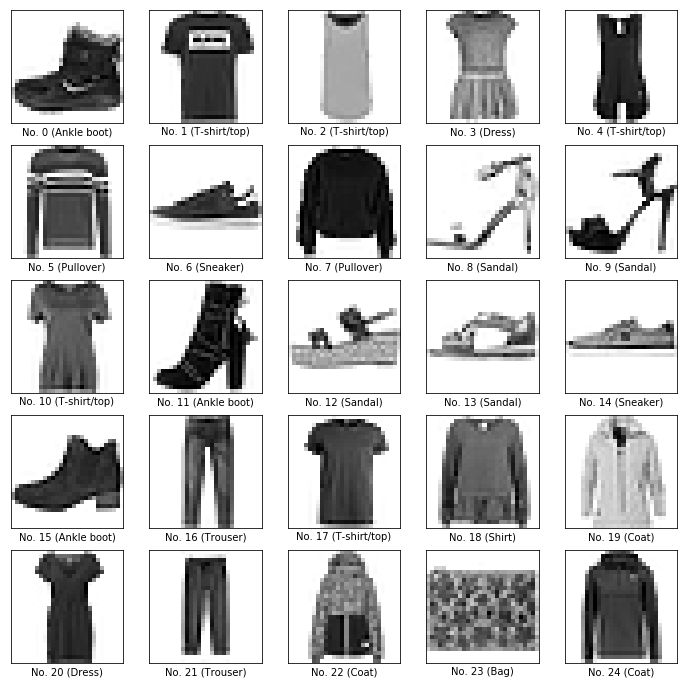

In [132]:
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([]), plt.yticks([])
    plt.xlabel("No. %d (%s)" %(i, label_dic[y_train[i]]))
    plt.imshow(X_train[i].reshape(28,28), cmap=plt.cm.binary)
plt.savefig('./mnist/visualization/samples.png')
#tls.save_image("./mnist/visualization/sample.png", X_train[0]) would be better to save sample outputs
#PIL.Image.fromarray(X_train.reshape((X_train.shape[0],28,28))[0]) is the visualisation part of the above saving code

- Create a dictionary that holds index information for each label.

In [133]:
idx_dic_train = {}
for i in range(10):
    idx_dic_train[i] = [idx for idx, label in enumerate(y_train) if label == i]
idx_dic_test = {}
for i in range(10):
    idx_dic_test[i] = [idx for idx, label in enumerate(y_test) if label == i]

- Visualise sample images for each fashion item.

There are 6000 images of T-shirt/top.
There are 6000 images of Trouser.
There are 6000 images of Pullover.
There are 6000 images of Dress.
There are 6000 images of Coat.
There are 6000 images of Sandal.
There are 6000 images of Shirt.
There are 6000 images of Sneaker.
There are 6000 images of Bag.
There are 6000 images of Ankle boot.


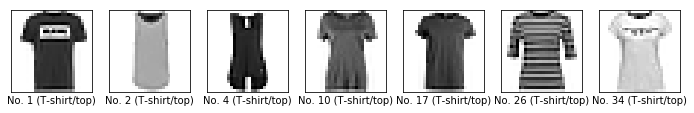

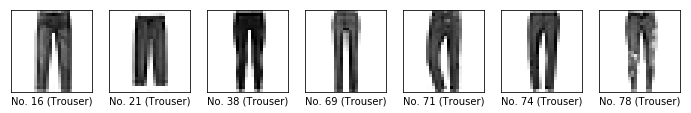

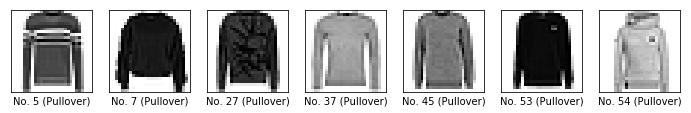

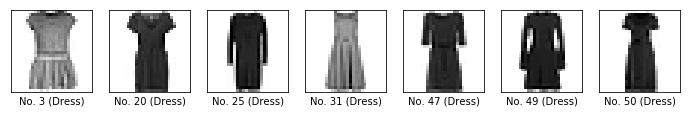

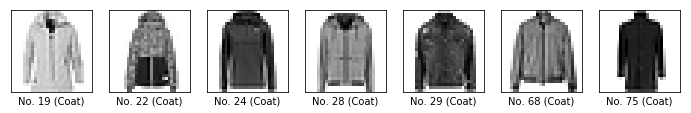

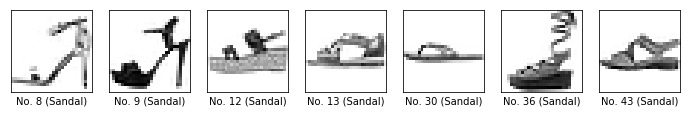

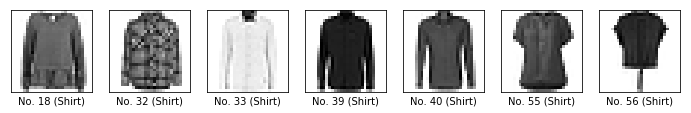

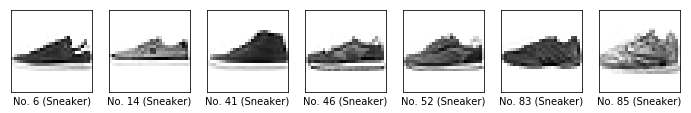

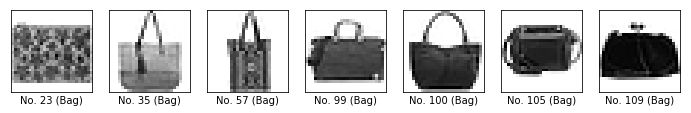

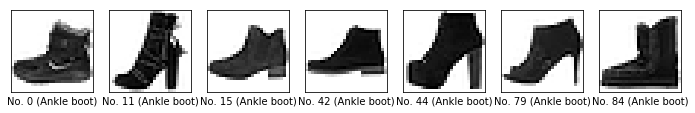

In [134]:
for i in range(10):
    print('There are %d images of %s.' %(len(idx_dic_train[i]), label_dic[i]))
    plt.figure(figsize=(12,12))
    for j in range(7):
        plt.subplot(1, 7, j+1)
        plt.xticks([]), plt.yticks([])
        plt.xlabel('No. %d (%s)' %(idx_dic_train[i][j], label_dic[i]))
        plt.imshow(X_train[idx_dic_train[i]][j].reshape(28,28), cmap=plt.cm.binary)
    plt.savefig('./mnist/visualization/sample_%d.png' %i)

- Here we create new test sets for each fashion item that are mixed with 10 items with different labels than its item.
- As the result, we have 1090 (1000 of the same item with 10 of items with 9 different lables). (i.e. 8.25% the data are polluted)

In [135]:
X_test_mixed_dic, y_test_mixed_dic = {}, {}

for i in range(10):
    labels_to_mix = [k for k in range(10) if k != i]
    X_test_mixed, y_test_mixed = X_test[idx_dic_test[i]], y_test[idx_dic_test[i]]
    
    for j in labels_to_mix:
        idx_to_mix = np.sort(random.sample(list(idx_dic_test[j]), 10))
        X_test_mixed, y_test_mixed = np.concatenate((X_test_mixed, X_test[idx_to_mix]), axis = 0), np.concatenate((y_test_mixed, y_test[idx_to_mix]), axis = 0)
    
    X_test_mixed_dic[i], y_test_mixed_dic[i] = X_test_mixed/255.0, y_test_mixed

## 2. Experiments

- One-class SVM  
https://scikit-learn.org/0.15/modules/generated/sklearn.svm.OneClassSVM.html

- In our first experiment, we run the One-class SVM on only T-shirt data to demonstrate how OSVM works (i.e. we can compute false positive rate and accuracy rate)
- In the second part, we do Novelty Detection using all the fashion items in the test set.

### 2.1. First Experiment
- In this experiment, we will try to measure the performance of OSVM by mixing impurities into the set of target objects.

In [183]:
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder

In [184]:
target_label = 0

In [185]:
# Normalise the data (otherwise training takes too much time)
X_train_, y_train_ = X_train[idx_dic_train[target_label]] / 255.0, y_train[idx_dic_train[target_label]]

In [186]:
X_test_, y_test_ = X_test_mixed_dic[target_label], y_test_mixed_dic[target_label]
X_train_.shape

(6000, 784)

In [190]:
clf = svm.OneClassSVM(kernel='rbf',
                      nu=0.05,
                      #degree=3,  # Only for ‘poly’; 3 by default
                      gamma='auto')  # Only for ‘rbf’, ‘poly’ and ‘sigmoid; 'auto' or float
                      #coef0=0.0)  # Only for ‘poly’ and ‘sigmoid’; 0.0 by default
clf.fit(X_train_)
y_pred_train = clf.predict(X_train_)
y_pred_test = clf.predict(X_test_)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
print(n_error_train, n_error_test)

299 98


In [191]:
pred_outlier_index = np.where(y_pred_test < 0)
pred_normal_index = np.where(y_pred_test > 0)
print('Labels whose image is classified as not 0 (T-shirt):')
y_test_[pred_outlier_index]

Labels whose image is classified as not 0 (T-shirt):


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=uint8)

In [192]:
TP = len([1 for i in y_test_[pred_normal_index] if i == 0])
FP = len([1 for i in y_test_[pred_normal_index] if i != 0])
FN = len([1 for i in y_test_[pred_outlier_index] if i == 0])
TN = len([1 for i in y_test_[pred_outlier_index] if i != 0])
TP_rate = TP/(TP+FN)
FP_rate = FP/(TN+FP)
FN_rate = FN/(TP+FN)
TN_rate = TN/(TN+FP)
Accurary = (TP + TN)/(TP+FP+FN+TN)
Precision = TP/(TP+FP)
Recall = TP/(TP+FN) # #positive(correct)/#T-shirt
Specificity = TN/(TN+FP)
F1_Score = (2 * Precision * Recall) / (Precision + Recall) 
print('True positive rate = {:.2%}'.format(TP_rate))
print('False positive rate = {:.2%}'.format(FP_rate))
print('False negative rate = {:.2%}'.format(FN_rate))
print('True negative rate = {:.2%}'.format(TN_rate))
print('Accuracy = {:.2%}'.format(Accurary))
print('Precision = {:.2%}'.format(Precision))
print('Recall = {:.2%}'.format(Recall))
print('Specificity = {:.2%}'.format(Specificity))
print('F1_Score = {:.2%}'.format(F1_Score))

True positive rate = 95.00%
False positive rate = 46.67%
False negative rate = 5.00%
True negative rate = 53.33%
Accuracy = 91.56%
Precision = 95.77%
Recall = 95.00%
Specificity = 53.33%
F1_Score = 95.38%


| $\nu = 0.05$ <br> / RBF kernel | Object from <br> target class | Object from <br> outlier class | 
|---|---|---|
| Classified as <br> a target object |True positive,<br> T+ = 95.0% |False positive,<br> F+ = 46.7%|
| Classified as <br> an outlier object |False negative,<br> F- = 5.0%|True negative,<br> F- = 53.3%|

- Accuracy = 91.56%
- Precision = 95.77%
- Recall = 95.00%
- Specificity = 53.33%
- F1_Score = 95.38%

| $\nu = 0.5$ <br> / RBF kernel | Object from <br> target class | Object from <br> outlier class | 
|---|---|---|
| Classified as <br> a target object |True positive,<br> T+ = 49.6% |False positive,<br> F+ = 4.4%|
| Classified as <br> an outlier object |False negative,<br> F- = 50.4%|True negative,<br> F- = 95.6%|

- Accuracy = 53.39%
- Precision = 99.20%
- Recall = 49.60%
- Specificity = 95.56%
- F1_Score = 66.13%

### 2.2. Second Experiment
- In this experiment, we will visualise the anomalies of T-shirts.

In [143]:
target_label = 0
#enc = OneHotEncoder(handle_unknown='ignore')
#enc.fit(y_test.reshape(-1, 1))
#y_test_onehot = enc.transform(y_test.reshape(-1, 1)).toarray()
X_test_, y_test_ = X_test[idx_dic_test[target_label]] / 255.0, y_test[idx_dic_test[target_label]]
#Input = np.concatenate((X_test/255.0, y_test_onehot), axis = 1)
print(X_test_.shape)

(1000, 784)


- We have the dimensionality of 794 as the input.

| T-shirt | nu | degree | gamma | coef0 |
|---|---|---|---|---|
| linear |0.01|×|×|×|
| poly |0.01|3|auto|0.0|
| rbf |0.01|×|auto (#anomalies increases if >> 0)|×|
| sigmoid |0.01|×|auto|0.0|

In [144]:
clf = svm.OneClassSVM(kernel='rbf',
                      nu=0.05,
                      #degree=3,  # Only for ‘poly’; 3 by default
                      gamma='auto')  # Only for ‘rbf’, ‘poly’ and ‘sigmoid; 'auto' or float
                      #coef0=0.0)  # Only for ‘poly’ and ‘sigmoid’; 0.0 by default
clf.fit(X_test_)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [162]:
scoring = clf.fit(X_test_)
score = scoring.decision_function(X_test_)

1.758073912054833

In [147]:
y_pred_test = clf.predict(X_test_)
pred_outlier_index = np.where(y_pred_test < 0)
pred_normal_index = np.where(y_pred_test > 0)

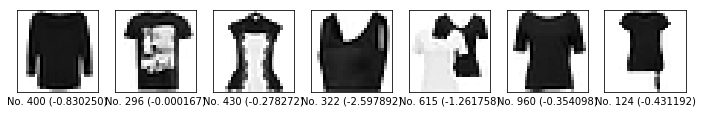

In [181]:
shuffled_outlier_index = random.sample(list(pred_outlier_index[0]), 7)
plt.figure(figsize=(12,12))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.xticks([]), plt.yticks([])
    plt.xlabel("No. %d (%f)" %(shuffled_outlier_index[i], score[shuffled_outlier_index[i]]))
    plt.imshow(X_test_[shuffled_outlier_index][i].reshape(28,28), cmap=plt.cm.binary)
plt.savefig('./mnist/visualization/outlier.png')

- Compare with the below sample images that were predicted to be normal. These indeed look regular styles of T-shirt to us.

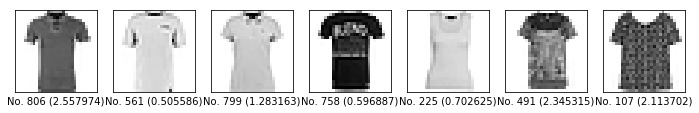

In [182]:
shuffled_normal_index = random.sample(list(pred_normal_index[0]), 7)
plt.figure(figsize=(12,12))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.xticks([]), plt.yticks([])
    plt.xlabel("No. %d (%f)" %(shuffled_normal_index[i], score[shuffled_normal_index[i]]))
    plt.imshow(X_test_[shuffled_normal_index][i].reshape(28,28), cmap=plt.cm.binary)
plt.savefig('./mnist/visualization/normal.png')

- We can see that sample T-shirt images predicted to be anomaly have indeed eccentric shape as a T-shirt. (Compare with the images of T-shirt that were predicted to be normal in the cell next.)

[MEMO]
- (T-shirt, rbf) detects outliers to be eccentric-shaped T-shirts.
- (T-shirt, linear/poly/sigmoid) detects outliers to be white (light colour) T-shirts.

- Please refer to our report for conclusion.